
(1) finished after 2560 timesteps, total profit: -751.9561575916972, memery: 1


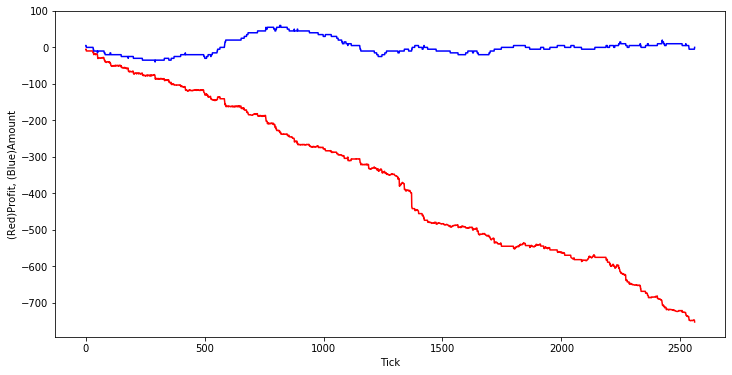

(2) finished after 5536 timesteps, total profit: -418.8547006551487, memery: 54


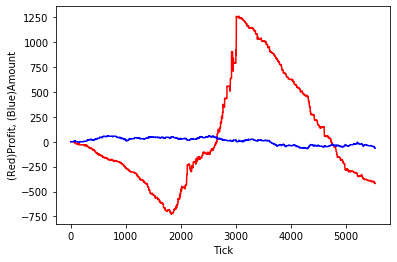

(3) finished after 1395 timesteps, total profit: -759.6641949203165, memery: 56
(4) finished after 5536 timesteps, total profit: -666.6740700014851, memery: 102


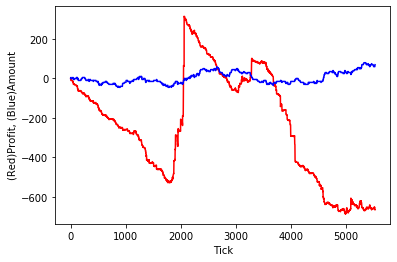

(5) finished after 5536 timesteps, total profit: 146.50709252700432, memery: 170


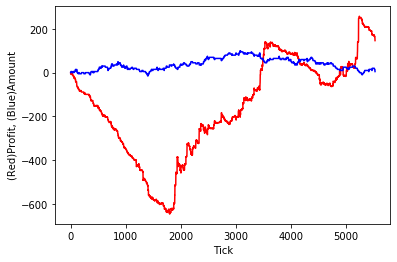

(6) finished after 1707 timesteps, total profit: -799.3606231484421, memery: 170
(7) finished after 5536 timesteps, total profit: 3415.06252508948, memery: 238


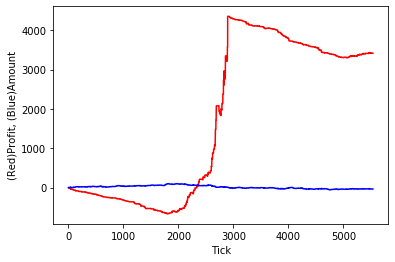

(8) finished after 1704 timesteps, total profit: -750.1563958344996, memery: 239
(9) finished after 1680 timesteps, total profit: -750.6806873710149, memery: 239
(10) finished after 1694 timesteps, total profit: -764.7258328656796, memery: 239
(11) finished after 2085 timesteps, total profit: -750.3891734798697, memery: 246


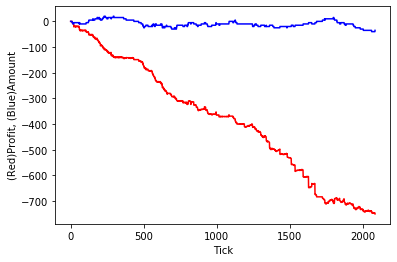

(12) finished after 1717 timesteps, total profit: -750.4107534504232, memery: 246
(13) finished after 1632 timesteps, total profit: -752.4693349537106, memery: 247
(14) finished after 5536 timesteps, total profit: 87.6172191758271, memery: 330


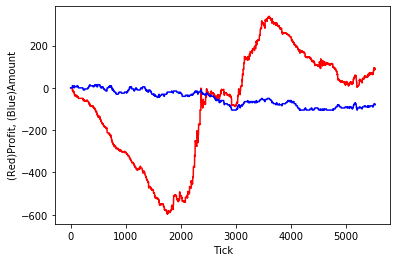

(15) finished after 5536 timesteps, total profit: 1855.1694272397162, memery: 450


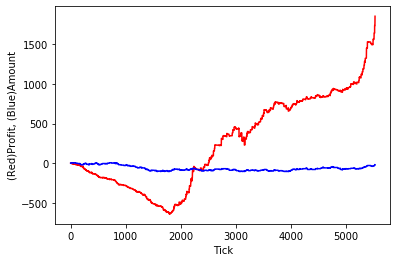

(16) finished after 1568 timesteps, total profit: -758.6003662941713, memery: 450
(17) finished after 3943 timesteps, total profit: -765.805212616433, memery: 467


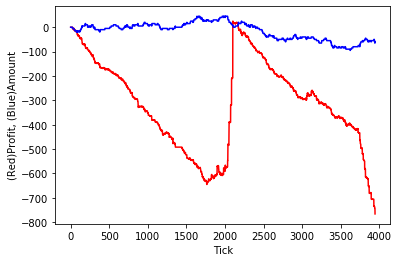

(18) finished after 1540 timesteps, total profit: -777.5819679780691, memery: 468
(19) finished after 1638 timesteps, total profit: -764.350947652964, memery: 468
(20) finished after 1558 timesteps, total profit: -751.4863619105273, memery: 469
(21) finished after 1644 timesteps, total profit: -755.0638401177287, memery: 469
(22) finished after 5536 timesteps, total profit: 1629.2423390003455, memery: 593


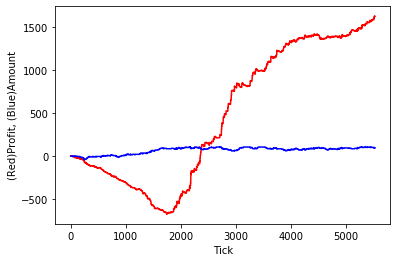

(23) finished after 5536 timesteps, total profit: 650.3453211323706, memery: 651


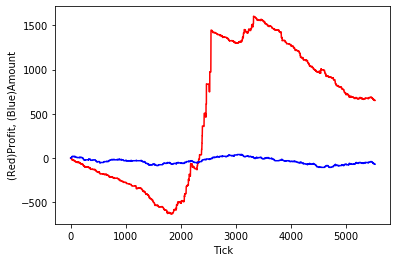

(24) finished after 1687 timesteps, total profit: -766.0601569368894, memery: 651
(25) finished after 1592 timesteps, total profit: -751.0521935940217, memery: 651
(26) finished after 3766 timesteps, total profit: -771.9076186266294, memery: 670


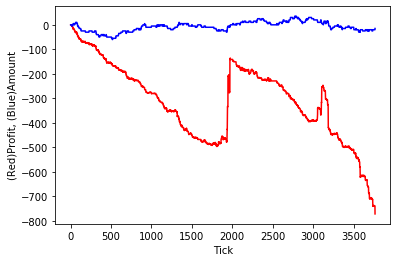

(27) finished after 5536 timesteps, total profit: 3382.0831652650486, memery: 789


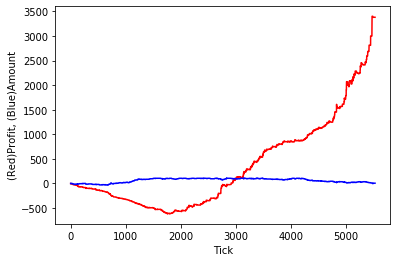

(28) finished after 4722 timesteps, total profit: -847.9671118034917, memery: 834


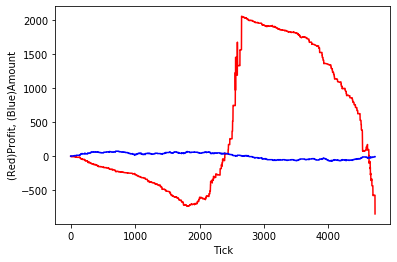

(29) finished after 1754 timesteps, total profit: -750.7975995649193, memery: 834
(30) finished after 1463 timesteps, total profit: -759.1864548071553, memery: 834
(31) finished after 1740 timesteps, total profit: -755.6751254010455, memery: 834
(32) finished after 1657 timesteps, total profit: -760.2212258364565, memery: 834
(33) finished after 5536 timesteps, total profit: -689.3827092375632, memery: 872


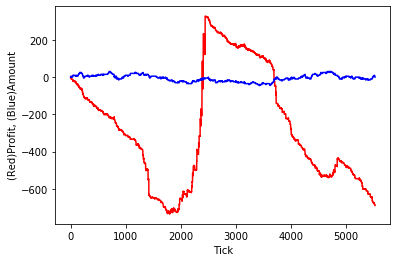

(34) finished after 1437 timesteps, total profit: -763.1900856833909, memery: 872
(35) finished after 1795 timesteps, total profit: -751.1653091781842, memery: 875
(36) finished after 1799 timesteps, total profit: -754.1095566958171, memery: 880
(37) finished after 1457 timesteps, total profit: -785.4021516632123, memery: 881
(38) finished after 1617 timesteps, total profit: -757.6732500231968, memery: 881
(39) finished after 1485 timesteps, total profit: -753.2867820877622, memery: 881
(40) finished after 3871 timesteps, total profit: -752.3758213107628, memery: 900


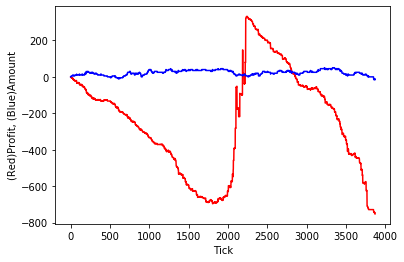

(41) finished after 5536 timesteps, total profit: 2172.812040470286, memery: 1014


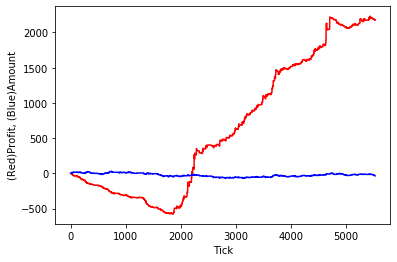

(42) finished after 1453 timesteps, total profit: -771.4097380856186, memery: 1014
(43) finished after 5536 timesteps, total profit: 2155.289264999607, memery: 1118


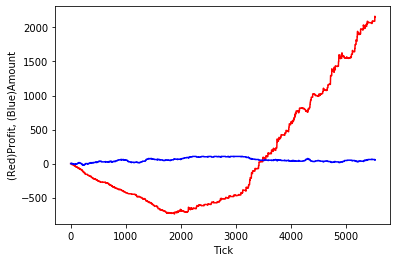

(44) finished after 5536 timesteps, total profit: 220.75295400329338, memery: 1198


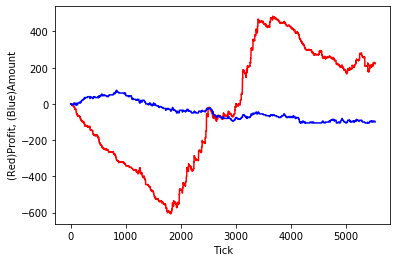

(45) finished after 1784 timesteps, total profit: -753.4873023019709, memery: 1198
(46) finished after 3921 timesteps, total profit: -750.4237473902056, memery: 1230


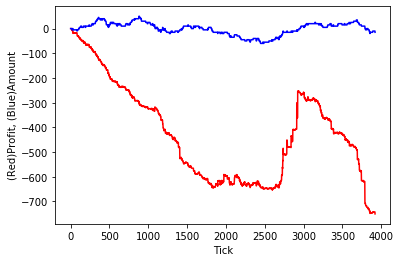

(47) finished after 4575 timesteps, total profit: -787.7922411790536, memery: 1288


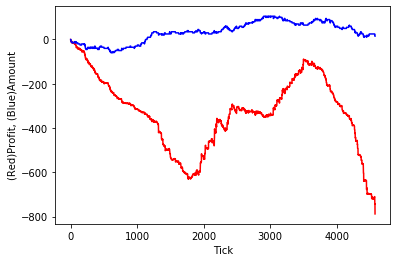

(48) finished after 1597 timesteps, total profit: -760.8439089119631, memery: 1288
(49) finished after 4577 timesteps, total profit: -750.2627117415963, memery: 1327


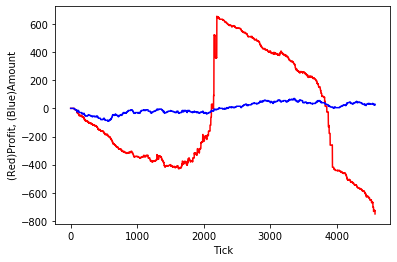

(50) finished after 1530 timesteps, total profit: -764.8369657355236, memery: 1327
(51) finished after 1679 timesteps, total profit: -757.0625873254698, memery: 1327
(52) finished after 4509 timesteps, total profit: -754.644117594086, memery: 1375


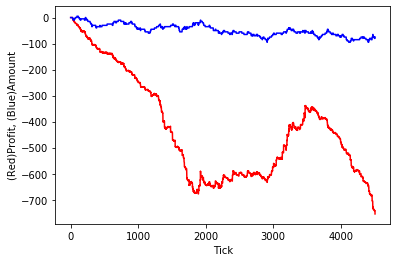

(53) finished after 1517 timesteps, total profit: -750.7553814166794, memery: 1375
(54) finished after 1988 timesteps, total profit: -770.2913840748116, memery: 1376
(55) finished after 5536 timesteps, total profit: 565.2403128100102, memery: 1444


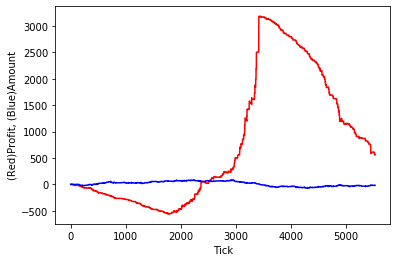

(56) finished after 4491 timesteps, total profit: -763.350380347182, memery: 1468


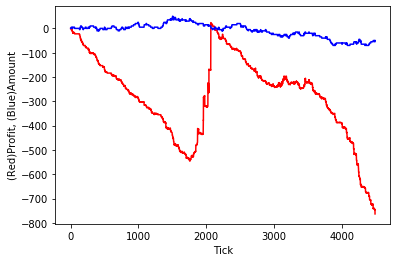

(57) finished after 5536 timesteps, total profit: 8084.096287614467, memery: 1597


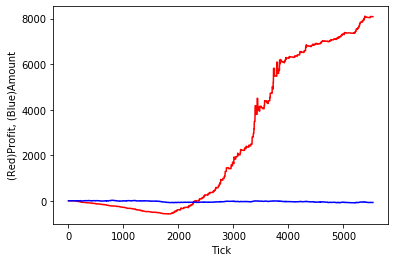

(58) finished after 1719 timesteps, total profit: -751.2866612922525, memery: 1597
(59) finished after 1535 timesteps, total profit: -772.1056040602102, memery: 1598
(60) finished after 5536 timesteps, total profit: 6044.130513485087, memery: 1739


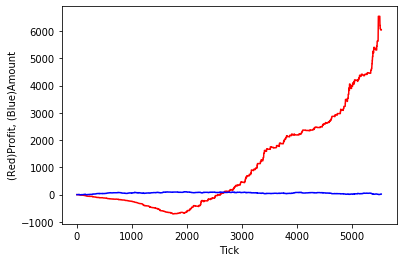

(61) finished after 5536 timesteps, total profit: -260.29047025302555, memery: 1803


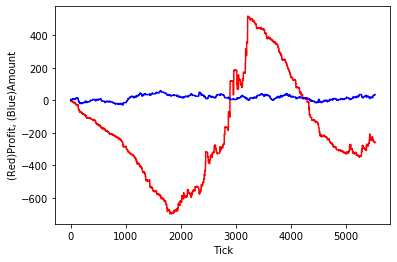

(62) finished after 5536 timesteps, total profit: -714.5965395606966, memery: 1850


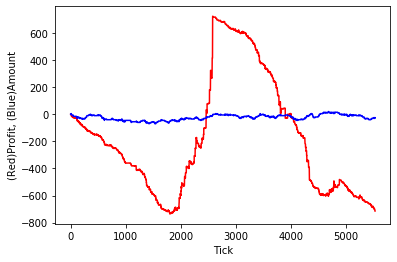

(63) finished after 1982 timesteps, total profit: -761.77427389002, memery: 1856
(64) finished after 1568 timesteps, total profit: -767.5418435925172, memery: 1858
(65) finished after 1513 timesteps, total profit: -770.8334315604048, memery: 1858
(66) finished after 1557 timesteps, total profit: -769.7021335073622, memery: 1858
(67) finished after 2229 timesteps, total profit: -752.5719709633349, memery: 1861


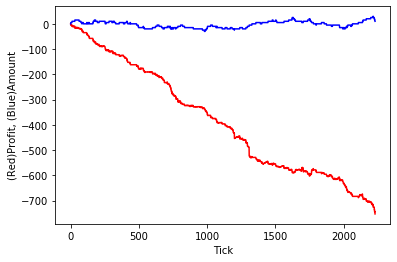

(68) finished after 1741 timesteps, total profit: -766.4750136056399, memery: 1861
(69) finished after 1649 timesteps, total profit: -757.1689798644182, memery: 1862
(70) finished after 1563 timesteps, total profit: -768.7505851221443, memery: 1862
(71) finished after 1803 timesteps, total profit: -750.1689627782976, memery: 1862
(72) finished after 2053 timesteps, total profit: -761.4651606119239, memery: 1862


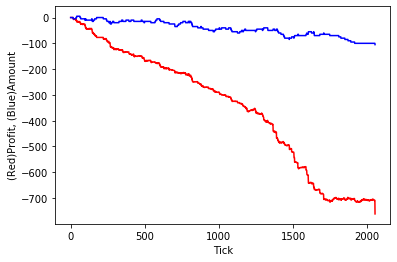

(73) finished after 5536 timesteps, total profit: 791.8164403029683, memery: 1918


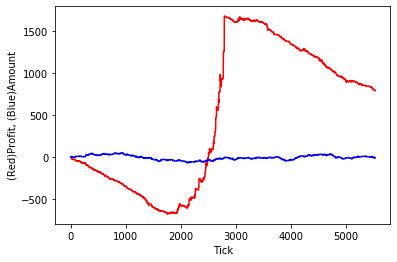

(74) finished after 1888 timesteps, total profit: -754.0141523437551, memery: 1918
(75) finished after 3911 timesteps, total profit: -751.3632367005985, memery: 1946


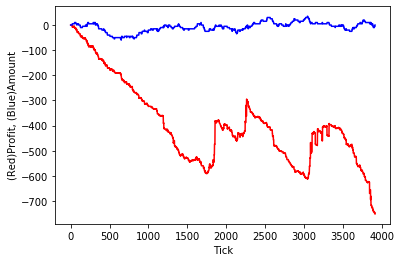

(76) finished after 1474 timesteps, total profit: -772.0143142873751, memery: 1946
(77) finished after 1735 timesteps, total profit: -750.5336206096163, memery: 1947
(78) finished after 3411 timesteps, total profit: -758.9005656327378, memery: 2033


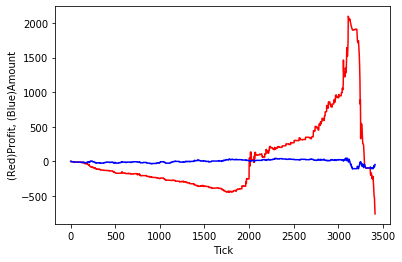

(79) finished after 355 timesteps, total profit: -751.9154157129605, memery: 2033
(80) finished after 377 timesteps, total profit: -751.4521414727953, memery: 2033
(81) finished after 386 timesteps, total profit: -754.3401673068637, memery: 2033
(82) finished after 172 timesteps, total profit: -752.8638824586108, memery: 2033
(83) finished after 208 timesteps, total profit: -753.060824791422, memery: 2033
(84) finished after 547 timesteps, total profit: -754.024523702695, memery: 2035
(85) finished after 148 timesteps, total profit: -756.601275311412, memery: 2035
(86) finished after 252 timesteps, total profit: -750.0090523522507, memery: 2035
(87) finished after 192 timesteps, total profit: -751.3338353127198, memery: 2035
(88) finished after 271 timesteps, total profit: -753.9954675599661, memery: 2035
(89) finished after 592 timesteps, total profit: -751.2099763535961, memery: 2035
(90) finished after 247 timesteps, total profit: -752.5542130228846, memery: 2037
(91) finished after

(178) finished after 224 timesteps, total profit: -754.625379016946, memery: 2065
(179) finished after 213 timesteps, total profit: -752.1234506053003, memery: 2065
(180) finished after 217 timesteps, total profit: -755.8558830671051, memery: 2067
(181) finished after 279 timesteps, total profit: -751.5619306007251, memery: 2067
(182) finished after 446 timesteps, total profit: -754.4117035964036, memery: 2069
(183) finished after 421 timesteps, total profit: -753.0615933905027, memery: 2069
(184) finished after 563 timesteps, total profit: -754.9539759285915, memery: 2069
(185) finished after 193 timesteps, total profit: -752.5932274399719, memery: 2069
(186) finished after 266 timesteps, total profit: -751.6066911849352, memery: 2070
(187) finished after 423 timesteps, total profit: -756.8867245008056, memery: 2071
(188) finished after 463 timesteps, total profit: -755.7091574268495, memery: 2072
(189) finished after 408 timesteps, total profit: -751.5373147842002, memery: 2073
(190)

(276) finished after 202 timesteps, total profit: -752.1369963194961, memery: 2118
(277) finished after 542 timesteps, total profit: -752.7570373556504, memery: 2119
(278) finished after 1051 timesteps, total profit: -752.2760558449476, memery: 2120
(279) finished after 252 timesteps, total profit: -755.6490631589911, memery: 2120
(280) finished after 540 timesteps, total profit: -751.4119165673504, memery: 2122
(281) finished after 254 timesteps, total profit: -753.9205285267357, memery: 2122
(282) finished after 525 timesteps, total profit: -751.2310609860527, memery: 2124
(283) finished after 364 timesteps, total profit: -754.2853297521578, memery: 2126
(284) finished after 1196 timesteps, total profit: -750.1167152838526, memery: 2126
(285) finished after 702 timesteps, total profit: -750.1049057171474, memery: 2126
(286) finished after 468 timesteps, total profit: -754.843564248068, memery: 2126
(287) finished after 326 timesteps, total profit: -753.2750270094963, memery: 2126
(28

(374) finished after 343 timesteps, total profit: -751.7376304177458, memery: 2227
(375) finished after 218 timesteps, total profit: -751.4518082238138, memery: 2227
(376) finished after 246 timesteps, total profit: -751.1531186245057, memery: 2227
(377) finished after 214 timesteps, total profit: -755.0005859458239, memery: 2227
(378) finished after 246 timesteps, total profit: -751.8164233839087, memery: 2227
(379) finished after 205 timesteps, total profit: -755.2399225304305, memery: 2227
(380) finished after 275 timesteps, total profit: -752.3804494146212, memery: 2227
(381) finished after 159 timesteps, total profit: -750.0874326104598, memery: 2227
(382) finished after 160 timesteps, total profit: -750.2967601593339, memery: 2227
(383) finished after 254 timesteps, total profit: -750.4872229579033, memery: 2227
(384) finished after 319 timesteps, total profit: -753.6904041184905, memery: 2228
(385) finished after 434 timesteps, total profit: -753.4659650963569, memery: 2228
(386

(472) finished after 242 timesteps, total profit: -750.6087002488609, memery: 2242
(473) finished after 211 timesteps, total profit: -757.8403454740993, memery: 2242
(474) finished after 330 timesteps, total profit: -751.7715649821059, memery: 2243


In [ ]:
%matplotlib inline
from trading_gym.env import TradeEnv
from datetime import datetime
import random
import matplotlib
import matplotlib.pylab as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
#matplotlib.use('tkAgg')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device =  torch.device("cpu")

def custom_obs_features_func(history, info):
    list = []
    for i in range(len(history.obs_list)):
        list.append(history.obs_list[i].close)
    
    return list

def custom_reward_func(exchange):
    #info
    '''
    {'index': 56, 'date': '2010-01-01 01:04', 'nav': 50000, 'amount': 250000, 'avg_price': 1.4325899999999998,
    'profit': {'total': -282.0124161115024, 'fixed': -272.23990618194, 'floating': -9.7725099295624},
    'buy_at': 52, 'latest_price': 1.43231}
    
    #print(exchange.info)
    #print('Profit: {} , floating: {} , fixed: {}'.format(exchange.profit, exchange.floating_profit, exchange.fixed_profit))
    
    # profit , index - 50
    if(exchange.floating_profit > 0):
        reward = exchange.floating_profit * (exchange.info["index"] - 50) * 0.001
    else:
        reward = exchange.profit * 0.001
    '''
    
    reward = exchange.floating_profit * 0.01
    #print(exchange.info["amount"])
    #print(exchange.available_actions)
    #print(reward)
    
    return reward

# Hyper Parameters
BATCH_SIZE = 32
LR = 0.01                   # learning rate
EPSILON = 0.9               # greedy policy
GAMMA = 0.9                 # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
MEMORY_CAPACITY = 2000
NAV = 5000
env = TradeEnv(data_path='eurusd_patterns_10_test2_slope_trend_pro.lite1-6.csv',
               ops_shape=[],
               get_obs_features_func=custom_obs_features_func,
               get_reward_func=custom_reward_func,
               nav=NAV, 
               data_kwargs={'use_ta': False}
              )

#nv = TradeEnv(data_path='eurusd_patterns_10_test2_slope_trend_pro.lite1-6.csv',ops_shape=[],get_obs_features_func=custom_obs_features_func,nav=1000,get_reward_func=custom_reward_func, data_kwargs={'use_ta': False})
#env = TradeEnv(data_path='eurusd_patterns_10_test2_slope_trend_pro.lite1-6.csv',nav=1000, data_kwargs={'use_ta': False})
env = env.unwrapped
N_ACTIONS = 3
N_STATES = 51
ENV_A_SHAPE = 0
n_episodes = 1000 #10000
PATH = "./training_game_01.h5"


class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 50).to(device)
        self.fc1.weight.data.normal_(0, 0.1)   # initialization
        self.fc2 = nn.Linear(50, 50).to(device)
        self.fc2.weight.data.normal_(0, 0.1)   # initialization
        self.out = nn.Linear(50, 50).to(device)
        self.out.weight.data.normal_(0, 0.1)   # initialization

    def forward(self, x):
        #print(x)
        #print(x.size())
        x = x.to(device)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        #print(x.size())
        actions_value = self.out(x)
        #print(actions_value)
        #print(actions_value.size())
        return actions_value


class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net().to(device), Net().to(device)

        self.learn_step_counter = 0                                     # for target updating
        self.memory_counter = 0                                         # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
        self.loss_func = nn.MSELoss()

    def choose_action(self, x):
        #print(x)
        x = torch.unsqueeze(torch.FloatTensor(x), 0).to(device)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.cpu().numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
            
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
            
        return action

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        # replace the old memory with new memory
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        b_s = torch.FloatTensor(b_memory[:, :N_STATES]).to(device)
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int)).to(device)
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2]).to(device)
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:]).to(device)

        # q_eval w.r.t the action in experience
        q_eval = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        q_next = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    

dqn = DQN()


print('\nCollecting experience...')
for i_episode in range(n_episodes):
    t = 0
    rewards = 0
    profit0 = 0
    obs0 = env.reset()
    x_list, y_list, z_list = [], [], [];
    while True:
        #env.render()
        action = dqn.choose_action(obs0)
        observation, reward, done, info = env.step(action)
        
        profit = info["profit"]["total"]
        

        #action 0 sell, 1 hold, 2 buy
        #print(info["profit"]["floating"])
        # 儲存 experience
        if((profit - profit0)/NAV > 0.001):
            dqn.store_transition(obs0, action, reward, observation)
        #print((profit-profit0)/5000) 
        
        
        profit0 = profit
        
        # 累積 reward
        #rewards += reward

        # 有足夠 experience 後進行訓練
        if dqn.memory_counter > MEMORY_CAPACITY:
            dqn.learn()
            #print(dqn.memory_counter)

        # 進入下一 state
        obs0 = observation
        
        
        x_list.append(t+1); y_list.append(info["profit"]["total"]); z_list.append(info["amount"]/1000);
       

        if(done):
            #torch.save(dqn, PATH)
            print('({}) finished after {} timesteps, total profit: {}, memery: {}'.format(i_episode+1, t+1, info["profit"]["total"],dqn.memory_counter))
            if((t+1) > 2000):
                plt.cla()
                plt.xlabel('Tick')
                plt.ylabel('(Red)Profit, (Blue)Amount')
                plt.plot(x_list, y_list, 'r')
                plt.plot(x_list, z_list, 'b')
                #plt.figure(tight_layout=True, linewidth=1, edgecolor='r')

                plt.show()
            break

        t += 1

env.close()

In [ ]:
%matplotlib inline
import matplotlib.pylab as plt
x_list, y_list, z_list = [], [], [];
x_list.append(1); y_list.append(2); z_list.append(3);
x_list.append(2); y_list.append(4); z_list.append(6);
x_list.append(3); y_list.append(5); z_list.append(3);


plt.cla()
plt.xlabel('Tick')
plt.ylabel('Profit')
plt.plot(x_list, y_list, 'r')
plt.plot(x_list, z_list, 'b')
plt.show()
